# Case Study 

# The site for recommendations: "Gnod"

![title](Files/image2.jpg)

### Importing Libraries

In [96]:
from bs4 import BeautifulSoup
import seaborn as sns
import statsmodels.formula.api as smf
import requests
import pandas as pd
import numpy as np
import spotipy
import json
from spotipy.oauth2 import SpotifyClientCredentials
import sys
from pandas import json_normalize
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
%matplotlib inline

## Loading credentials from another config file

In [2]:
from credentials import *

## Starting with Spotify API

##### Acessing credentials

In [12]:
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id= client_id, client_secret= client_secret))

# The "sp" variable has two useful funtions:
# The first usefull function is:
# .search(q='',limit=n)
# Where the "q" keyword is the query you want to perform on spotify: song_name, artist,...
# while The "limit" keyword will limit the number of returned results.
#
# The second usefull function is:
# .audio_features([URL|URI|ID])
# which returns some 'features of the song', that after cleanup, we can use in order to characterize a song.

results = sp.search(q='Foo Fighters', limit=5)
#results

##### Using Spotipy

    (1) sp.search (query="str", limit=n) = to perform queries
    (2) sp.audio_features = returns some 'features of the song

## Loading the Kaggle Dataset

In [4]:
data = pd.read_csv('Files/Kaggle_Spotify/data.csv')
display(data)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.98200,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.6650,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.73200,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.1600,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.96100,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.1010,-14.850,1,Gati Bali,5,1921,0.0339,110.339
3,0.1650,1921,0.96700,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.3810,-9.316,1,Danny Boy,3,1921,0.0354,100.109
4,0.2530,1921,0.95700,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.2290,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170648,0.6080,2020,0.08460,"['Anuel AA', 'Daddy Yankee', 'KAROL G', 'Ozuna...",0.786,301714,0.808,0,0KkIkfsLEJbrcIhYsCL7L5,0.000289,7,0.0822,-3.702,1,China,72,2020-05-29,0.0881,105.029
170649,0.7340,2020,0.20600,['Ashnikko'],0.717,150654,0.753,0,0OStKKAuXlxA0fMH54Qs6E,0.000000,7,0.1010,-6.020,1,Halloweenie III: Seven Days,68,2020-10-23,0.0605,137.936
170650,0.6370,2020,0.10100,['MAMAMOO'],0.634,211280,0.858,0,4BZXVFYCb76Q0Klojq4piV,0.000009,4,0.2580,-2.226,0,AYA,76,2020-11-03,0.0809,91.688
170651,0.1950,2020,0.00998,['Eminem'],0.671,337147,0.623,1,5SiZJoLXp3WOl3J4C8IK0d,0.000008,2,0.6430,-7.161,1,Darkness,70,2020-01-17,0.3080,75.055


## Checking the current Billboard's Hot 100 songs

#### First approach (Example):
    > Check the Billboard website and do the web-scraping on the HOT 100

#### Second approach (Selected):

    > Use the API to extract the Billboard Hot 100 songs direct from the Spotify
    > They are available on Spotify as a Playlist:  https://open.spotify.com/playlist/6UeSakyzhiEt4NB3UAd6NQ


![title](Files/billboard_spotify.png)


## First Approach:

##### Example of HOT 100 songs


In [5]:
hot_id_list = ['4BJqT0PrAfrxzMOxytFOIz', '7xPhfUan2yNtyFG0cUWkt8', '1o6I8BglA6ylDMrIELygv1', '0KkIkfsLEJbrcIhYsCL7L5']

In [8]:
data_hot_100 = []

for i in range(len(hot_id_list)):
    if any(data['id'].str.contains(hot_id_list[i], regex=False)) == True:
        data_hot_100.append(pd.DataFrame(data.iloc[i]).transpose())

data_hot_100

[  valence  year acousticness  \
 0  0.0594  1921        0.982   
 
                                              artists danceability duration_ms  \
 0  ['Sergei Rachmaninoff', 'James Levine', 'Berli...        0.279      831667   
 
   energy explicit                      id instrumentalness key liveness  \
 0  0.211        0  4BJqT0PrAfrxzMOxytFOIz            0.878  10    0.665   
 
   loudness mode                                               name popularity  \
 0  -20.096    1  Piano Concerto No. 3 in D Minor, Op. 30: III. ...          4   
 
   release_date speechiness   tempo  
 0         1921      0.0366  80.954  ,
   valence  year acousticness         artists danceability duration_ms energy  \
 1   0.963  1921        0.732  ['Dennis Day']        0.819      180533  0.341   
 
   explicit                      id instrumentalness key liveness loudness  \
 1        0  7xPhfUan2yNtyFG0cUWkt8                0   7     0.16  -12.441   
 
   mode                     name popularity rel

## Concatenating the results into a single dataframe

In [9]:
pd.concat(data_hot_100)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.963,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0,7,0.16,-12.441,1,Clancy Lowered the Boom,5,1921,0.415,60.936
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913,3,0.101,-14.85,1,Gati Bali,5,1921,0.0339,110.339
3,0.165,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,2.77e-05,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109


### Recap

##### So far we have:

    data = entire Dataset
    data_hot_100 = Hot 100 from Billboard's website

## Second approach

##### Billboard's playlist URL

In [10]:
url = 'https://open.spotify.com/playlist/6UeSakyzhiEt4NB3UAd6NQ'

##### In our case the playlist will be the Billboard Hot 100

In [13]:
playlist = sp.user_playlist_tracks("spotify", "6UeSakyzhiEt4NB3UAd6NQ")

In [17]:
print("Total number of songs in the playlist: ", playlist["total"])
len(playlist["items"])

Total number of songs in the playlist:  100


100

### Extracting the songs from the playlist

In [21]:
def get_playlist_tracks(username, playlist_id):
    results = sp.user_playlist_tracks(username,playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks

### Getting the artists from the tracks 

In [22]:
def get_artists_from_track(track):
    return[artist["name"] for artist in track["artists"]]

### Getting the artists' IDs from the tracks

In [23]:
def get_artists_ids_from_track(track):
    return[artist["id"] for artist in track["artists"]]

### Getting the artists from the playlist 

In [24]:
def get_artists_from_playlist(playlist_id):
    tracks_from_playlist = get_playlist_tracks("spotify", playlist_id)
    return list(set(artist for subset in [get_artists_from_track(track["track"]) for track in tracks_from_playlist] for artist in subset))

### Getting the artists' IDs from the playlist

In [25]:
def get_artists_ids_from_playlist(playlist_id):
    tracks_from_playlist = get_playlist_tracks("spotify", playlist_id)
    return list(set(artist for subset in [get_artists_ids_from_track(track["track"]) for track in tracks_from_playlist] for artist in subset))

In [30]:
artists = get_artists_from_playlist("6UeSakyzhiEt4NB3UAd6NQ")
artists_ids = get_artists_ids_from_playlist("6UeSakyzhiEt4NB3UAd6NQ")
print("The number of artists on the playlist is:", len(artists))
print()
print("The number of artists' ids on the playlist is:", len(artists_ids))

The number of artists on the playlist is: 112

The number of artists' ids on the playlist is: 113


### Getting albuns from artists

In [31]:
def get_albums_from_artist(artist_id):
    results = sp.artist_albums(artist_id, limit = 50)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks

### Same for albums ids

In [32]:
def get_album_ids_from_artist(artist_id):
    results = sp.artist_albums(artist_id, limit = 50)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return [i["id"] for i in tracks]

### Getting the songs of a given album

In [33]:
def get_track_ids_from_albums(album_ids):
    return list(set([i["id"] for j in album_ids for i in sp.album(j)["tracks"]["items"]]))

# Recommender System (Hot 100)

In [34]:
data_hot_100_billboard = get_playlist_tracks("spotify", "6UeSakyzhiEt4NB3UAd6NQ")

##### Getting the track id from the Billboard playlist

In [36]:
hot_100_list_billboard = []

for i in range(len(data_hot_100_billboard)):
    h1s = data_hot_100_billboard[i]['track']['id']
    hot_100_list_billboard.append(h1s)

In [40]:
display(pd.DataFrame({'id': hot_100_list_billboard}))

,id
0,3tjFYV6RSFtuktYl3ZtYcq
1,7igeByaBM0MgGsgXtNxDJ7
2,5cYFwgA5dHoqR3xGnlr9ew
3,2SAqBLGA283SUiwJ3xOUVI
4,0VjIjW4GlUZAMYd2vXMi3b
...,...
95,59qrUpoplZxbIZxk6X0Bm3
96,5vGLcdRuSbUhD8ScwsGSdA
97,7Dx9Z6Aon1qPS2N0rHSWTe
98,0DYNL4xbYWgNzppUamtyR4


### Creating the HOT 100 match dataframe

In [41]:
matching_entries = data.loc[data['id'].isin(hot_100_list_billboard)]
display(matching_entries)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
19281,0.352,2018,0.07910,['Jameson Rodgers'],0.431,184893,0.831,0,54eUv9Q3D9MZuOGS5PSflp,0.000000,8,0.3120,-5.108,1,Some Girls,74,2018-01-19,0.0474,167.960
19417,0.254,2019,0.21000,['Harry Styles'],0.448,208907,0.838,0,45S5WTQEGOB1VHr1Q4FuPl,0.000131,4,0.1310,-5.257,0,Golden,89,2019-12-13,0.0557,139.863
19422,0.670,2019,0.82700,['Luke Combs'],0.552,219573,0.225,0,6gdLyYNuhWBzqwlOFSsXC7,0.000000,0,0.1110,-11.501,1,Better Together,80,2019-11-08,0.0477,138.002
19434,0.303,2019,0.62100,['Jason Aldean'],0.512,178147,0.580,0,4TCc369aRPRubv1m8R1TBG,0.000017,3,0.5130,-6.658,0,Got What I Got,78,2019-11-22,0.0290,159.847
19435,0.385,2019,0.00531,['Parker McCollum'],0.562,244798,0.683,0,6vC90OOjZR165Hw8CpsqEm,0.000000,7,0.1070,-4.427,1,Pretty Heart,78,2019-08-30,0.0296,132.003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75156,0.939,2020,0.02720,['Lady A'],0.523,185070,0.927,0,48F2xnWq3LuzYWML327Z2r,0.000006,4,0.1680,-2.796,1,Champagne Night - From Songland,70,2020-06-12,0.0489,149.929
75222,0.356,2020,0.00522,"['King Von', 'Lil Durk']",0.793,144787,0.462,1,4g27tVPyGHi38dczFoJZZy,0.000000,5,0.1910,-7.495,0,All These Niggas (feat. Lil Durk),70,2020-10-30,0.1190,145.962
92316,0.641,2020,0.13200,['Niko Moon'],0.790,214707,0.646,0,5Kpg1A7BOHpBbaT3H3xqd3,0.000000,5,0.2950,-5.878,1,GOOD TIME,67,2020-02-14,0.0447,138.047
124817,0.650,2020,0.13800,"['Ne-Yo', 'Jeremih']",0.626,208216,0.592,1,3862MQcbNmghGJDfk8cOJi,0.000312,6,0.0957,-7.085,1,U 2 Luv,68,2020-05-29,0.1470,177.715


#### Message:

    The Kaggle dataset it was updated recently but, even though, there are some missing songs (14 entries).
    We'll get the missing information directly from Spotify by using the API

### Creating the regular song dataframe

In [42]:
non_matching_entries = data.loc[~data['id'].isin(hot_100_list_billboard)]
display(non_matching_entries)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.98200,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.6650,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.73200,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.1600,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.96100,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.1010,-14.850,1,Gati Bali,5,1921,0.0339,110.339
3,0.1650,1921,0.96700,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.3810,-9.316,1,Danny Boy,3,1921,0.0354,100.109
4,0.2530,1921,0.95700,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.2290,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170648,0.6080,2020,0.08460,"['Anuel AA', 'Daddy Yankee', 'KAROL G', 'Ozuna...",0.786,301714,0.808,0,0KkIkfsLEJbrcIhYsCL7L5,0.000289,7,0.0822,-3.702,1,China,72,2020-05-29,0.0881,105.029
170649,0.7340,2020,0.20600,['Ashnikko'],0.717,150654,0.753,0,0OStKKAuXlxA0fMH54Qs6E,0.000000,7,0.1010,-6.020,1,Halloweenie III: Seven Days,68,2020-10-23,0.0605,137.936
170650,0.6370,2020,0.10100,['MAMAMOO'],0.634,211280,0.858,0,4BZXVFYCb76Q0Klojq4piV,0.000009,4,0.2580,-2.226,0,AYA,76,2020-11-03,0.0809,91.688
170651,0.1950,2020,0.00998,['Eminem'],0.671,337147,0.623,1,5SiZJoLXp3WOl3J4C8IK0d,0.000008,2,0.6430,-7.161,1,Darkness,70,2020-01-17,0.3080,75.055


In [46]:
hot_100_list_billboard2 = pd.DataFrame({'id': hot_100_list_billboard})
hot_100_list_billboard2

,id
0,3tjFYV6RSFtuktYl3ZtYcq
1,7igeByaBM0MgGsgXtNxDJ7
2,5cYFwgA5dHoqR3xGnlr9ew
3,2SAqBLGA283SUiwJ3xOUVI
4,0VjIjW4GlUZAMYd2vXMi3b
...,...
95,59qrUpoplZxbIZxk6X0Bm3
96,5vGLcdRuSbUhD8ScwsGSdA
97,7Dx9Z6Aon1qPS2N0rHSWTe
98,0DYNL4xbYWgNzppUamtyR4


In [49]:
results_mad = pd.merge(hot_100_list_billboard2, matching_entries, how='outer', on='id')
display(results_mad)

,id,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,3tjFYV6RSFtuktYl3ZtYcq,0.756,2020.0,0.22100,"['24kGoldn', 'iann dior']",0.700,140526.0,0.722,1.0,0.000000,7.0,0.2720,-3.558,0.0,Mood (feat. iann dior),99.0,2020-07-24,0.0369,90.989
1,7igeByaBM0MgGsgXtNxDJ7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5cYFwgA5dHoqR3xGnlr9ew,0.409,2020.0,0.17100,"['Gabby Barrett', 'Charlie Puth']",0.554,209763.0,0.576,0.0,0.000000,6.0,0.1590,-6.495,1.0,I Hope (feat. Charlie Puth),73.0,2020-06-19,0.0399,74.942
3,2SAqBLGA283SUiwJ3xOUVI,0.522,2020.0,0.24400,"['Drake', 'Lil Durk']",0.761,261493.0,0.518,1.0,0.000035,0.0,0.1070,-8.871,1.0,Laugh Now Cry Later (feat. Lil Durk),93.0,2020-08-14,0.1340,133.976
4,0VjIjW4GlUZAMYd2vXMi3b,0.334,2020.0,0.00146,['The Weeknd'],0.514,200040.0,0.730,0.0,0.000095,1.0,0.0897,-5.934,1.0,Blinding Lights,96.0,2020-03-20,0.0598,171.005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,59qrUpoplZxbIZxk6X0Bm3,0.753,2020.0,0.03320,['Jason Derulo'],0.789,190306.0,0.711,0.0,0.000000,2.0,0.0876,-4.248,1.0,Take You Dancing,92.0,2020-07-22,0.0410,112.985
96,5vGLcdRuSbUhD8ScwsGSdA,0.737,2020.0,0.19000,['CJ'],0.711,123429.0,0.598,1.0,0.000000,3.0,0.1500,-7.621,0.0,Whoopty,84.0,2020-08-20,0.1820,140.175
97,7Dx9Z6Aon1qPS2N0rHSWTe,0.464,2020.0,0.08000,['Ariana Grande'],0.719,149900.0,0.607,1.0,0.000000,8.0,0.1250,-5.156,1.0,just like magic,85.0,2020-10-30,0.1650,128.006
98,0DYNL4xbYWgNzppUamtyR4,0.296,2020.0,0.06930,"['The Kid LAROI', 'Machine Gun Kelly']",0.721,144860.0,0.632,1.0,0.000000,5.0,0.2910,-6.695,0.0,"F*CK YOU, GOODBYE (feat. Machine Gun Kelly)",80.0,2020-11-06,0.0358,92.057


### Songs not present on the Kaggle dataset

In [50]:
results_mad2 = results_mad[results_mad['valence'].isnull()]
results_mad2

,id,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
1,7igeByaBM0MgGsgXtNxDJ7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,7ytR5pFWmSjzHJIeQkgog4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,76nqCfJOcFFWBJN32PAksn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,0v1x6rN6JHRapa03JElljE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,6FniJZn4agmDtPx1pKZQsa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,45npF3MKvCa1sO7s4y7qBf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37,7y7w4tl4MaRC2UMEj1mPtr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,7fPuWrlpwDcHm5aHCH5D9t,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,70rFIfYN7lU6iTgUIVP42w,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,0Z0kNthq0sS4lvGz9SSlBF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Getting uris from the songs missing in the playlist

In [54]:
def get_tracks_ids_from_playlist(playlist_id):
    
    final_results = []
    result = sp.playlist_tracks(playlist_id)
    final_results.extend(result["items"])
    
    while result["next"]:
        
        result = sp.next(result)
        final_results.extend(result["items"])
        
    ids = [track["track"]["id"] for track in final_results]
    
    # we return only values that are not None:
    return [i for i in ids if i]

#get_tracks_ids_from_playlist("https://open.spotify.com/playlist/6UeSakyzhiEt4NB3UAd6NQ")

### Building a dataframe with all the audio features

In [52]:
def get_audio_features_df(playlist_id):
    track_ids = get_tracks_ids_from_playlist(playlist_id)
    aud_feat = [sp.audio_features(track)[0] for track in track_ids]
    return pd.DataFrame(aud_feat)

In [55]:
audio_f = get_audio_features_df("https://open.spotify.com/playlist/6UeSakyzhiEt4NB3UAd6NQ")
display(audio_f)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.700,0.722,7,-3.558,0,0.0369,0.22100,0.000000,0.2720,0.756,90.989,audio_features,3tjFYV6RSFtuktYl3ZtYcq,spotify:track:3tjFYV6RSFtuktYl3ZtYcq,https://api.spotify.com/v1/tracks/3tjFYV6RSFtu...,https://api.spotify.com/v1/audio-analysis/3tjF...,140526,4
1,0.736,0.802,0,-4.759,1,0.0864,0.46800,0.000000,0.0940,0.675,144.005,audio_features,7igeByaBM0MgGsgXtNxDJ7,spotify:track:7igeByaBM0MgGsgXtNxDJ7,https://api.spotify.com/v1/tracks/7igeByaBM0Mg...,https://api.spotify.com/v1/audio-analysis/7ige...,172325,4
2,0.554,0.576,6,-6.495,1,0.0399,0.17100,0.000000,0.1590,0.409,74.942,audio_features,5cYFwgA5dHoqR3xGnlr9ew,spotify:track:5cYFwgA5dHoqR3xGnlr9ew,https://api.spotify.com/v1/tracks/5cYFwgA5dHoq...,https://api.spotify.com/v1/audio-analysis/5cYF...,209763,4
3,0.761,0.518,0,-8.871,1,0.1340,0.24400,0.000035,0.1070,0.522,133.976,audio_features,2SAqBLGA283SUiwJ3xOUVI,spotify:track:2SAqBLGA283SUiwJ3xOUVI,https://api.spotify.com/v1/tracks/2SAqBLGA283S...,https://api.spotify.com/v1/audio-analysis/2SAq...,261493,4
4,0.514,0.730,1,-5.934,1,0.0598,0.00146,0.000095,0.0897,0.334,171.005,audio_features,0VjIjW4GlUZAMYd2vXMi3b,spotify:track:0VjIjW4GlUZAMYd2vXMi3b,https://api.spotify.com/v1/tracks/0VjIjW4GlUZA...,https://api.spotify.com/v1/audio-analysis/0VjI...,200040,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.789,0.711,2,-4.248,1,0.0410,0.03320,0.000000,0.0876,0.753,112.985,audio_features,59qrUpoplZxbIZxk6X0Bm3,spotify:track:59qrUpoplZxbIZxk6X0Bm3,https://api.spotify.com/v1/tracks/59qrUpoplZxb...,https://api.spotify.com/v1/audio-analysis/59qr...,190306,4
96,0.711,0.598,3,-7.621,0,0.1820,0.19000,0.000000,0.1500,0.737,140.175,audio_features,5vGLcdRuSbUhD8ScwsGSdA,spotify:track:5vGLcdRuSbUhD8ScwsGSdA,https://api.spotify.com/v1/tracks/5vGLcdRuSbUh...,https://api.spotify.com/v1/audio-analysis/5vGL...,123429,4
97,0.719,0.607,8,-5.156,1,0.1650,0.08000,0.000000,0.1250,0.464,128.006,audio_features,7Dx9Z6Aon1qPS2N0rHSWTe,spotify:track:7Dx9Z6Aon1qPS2N0rHSWTe,https://api.spotify.com/v1/tracks/7Dx9Z6Aon1qP...,https://api.spotify.com/v1/audio-analysis/7Dx9...,149900,4
98,0.721,0.632,5,-6.695,0,0.0358,0.06930,0.000000,0.2910,0.296,92.057,audio_features,0DYNL4xbYWgNzppUamtyR4,spotify:track:0DYNL4xbYWgNzppUamtyR4,https://api.spotify.com/v1/tracks/0DYNL4xbYWgN...,https://api.spotify.com/v1/audio-analysis/0DYN...,144860,4


In [56]:
display(results_mad2)

,id,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
1,7igeByaBM0MgGsgXtNxDJ7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,7ytR5pFWmSjzHJIeQkgog4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,76nqCfJOcFFWBJN32PAksn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,0v1x6rN6JHRapa03JElljE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,6FniJZn4agmDtPx1pKZQsa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,45npF3MKvCa1sO7s4y7qBf,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37,7y7w4tl4MaRC2UMEj1mPtr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,7fPuWrlpwDcHm5aHCH5D9t,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,70rFIfYN7lU6iTgUIVP42w,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,0Z0kNthq0sS4lvGz9SSlBF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Getting the uri from the missing songs

In [57]:
results_mad3 = audio_f[audio_f['id'].isin(results_mad2['id'])]
results_mad3

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
1,0.736,0.802,0,-4.759,1,0.0864,0.46800,0.000000,0.0940,0.6750,144.005,audio_features,7igeByaBM0MgGsgXtNxDJ7,spotify:track:7igeByaBM0MgGsgXtNxDJ7,https://api.spotify.com/v1/tracks/7igeByaBM0Mg...,https://api.spotify.com/v1/audio-analysis/7ige...,172325,4
13,0.746,0.690,11,-7.956,1,0.1640,0.24700,0.000000,0.1010,0.4970,89.977,audio_features,7ytR5pFWmSjzHJIeQkgog4,spotify:track:7ytR5pFWmSjzHJIeQkgog4,https://api.spotify.com/v1/tracks/7ytR5pFWmSjz...,https://api.spotify.com/v1/audio-analysis/7ytR...,181733,4
14,0.638,0.688,1,-4.056,0,0.0407,0.00775,0.000000,0.1260,0.4340,129.856,audio_features,76nqCfJOcFFWBJN32PAksn,spotify:track:76nqCfJOcFFWBJN32PAksn,https://api.spotify.com/v1/tracks/76nqCfJOcFFW...,https://api.spotify.com/v1/audio-analysis/76nq...,162399,4
16,0.746,0.765,6,-4.410,0,0.0993,0.01120,0.000000,0.0936,0.7370,114.044,audio_features,0v1x6rN6JHRapa03JElljE,spotify:track:0v1x6rN6JHRapa03JElljE,https://api.spotify.com/v1/tracks/0v1x6rN6JHRa...,https://api.spotify.com/v1/audio-analysis/0v1x...,199054,4
18,0.621,0.882,6,-5.010,1,0.0459,0.60100,0.000000,0.1320,0.5740,126.014,audio_features,6FniJZn4agmDtPx1pKZQsa,spotify:track:6FniJZn4agmDtPx1pKZQsa,https://api.spotify.com/v1/tracks/6FniJZn4agmD...,https://api.spotify.com/v1/audio-analysis/6Fni...,216573,4
21,0.929,0.667,8,-6.789,0,0.3530,0.01850,0.000000,0.1000,0.2740,126.998,audio_features,45npF3MKvCa1sO7s4y7qBf,spotify:track:45npF3MKvCa1sO7s4y7qBf,https://api.spotify.com/v1/tracks/45npF3MKvCa1...,https://api.spotify.com/v1/audio-analysis/45np...,155168,4
37,0.625,0.814,0,-5.181,1,0.0657,0.01720,0.000000,0.1580,0.5350,144.991,audio_features,7y7w4tl4MaRC2UMEj1mPtr,spotify:track:7y7w4tl4MaRC2UMEj1mPtr,https://api.spotify.com/v1/tracks/7y7w4tl4MaRC...,https://api.spotify.com/v1/audio-analysis/7y7w...,205485,4
45,0.785,0.721,8,-5.457,1,0.0506,0.01490,0.004320,0.2850,0.8940,121.962,audio_features,7fPuWrlpwDcHm5aHCH5D9t,spotify:track:7fPuWrlpwDcHm5aHCH5D9t,https://api.spotify.com/v1/tracks/7fPuWrlpwDcH...,https://api.spotify.com/v1/audio-analysis/7fPu...,176219,4
59,0.728,0.685,5,-5.096,0,0.0433,0.00391,0.000000,0.1520,0.3300,124.934,audio_features,70rFIfYN7lU6iTgUIVP42w,spotify:track:70rFIfYN7lU6iTgUIVP42w,https://api.spotify.com/v1/tracks/70rFIfYN7lU6...,https://api.spotify.com/v1/audio-analysis/70rF...,138970,4
62,0.625,0.775,0,-5.199,1,0.0248,0.43100,0.000052,0.1200,0.5880,101.961,audio_features,0Z0kNthq0sS4lvGz9SSlBF,spotify:track:0Z0kNthq0sS4lvGz9SSlBF,https://api.spotify.com/v1/tracks/0Z0kNthq0sS4...,https://api.spotify.com/v1/audio-analysis/0Z0k...,210123,4


In [58]:
display(data)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.98200,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.6650,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.73200,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.1600,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.96100,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.1010,-14.850,1,Gati Bali,5,1921,0.0339,110.339
3,0.1650,1921,0.96700,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.3810,-9.316,1,Danny Boy,3,1921,0.0354,100.109
4,0.2530,1921,0.95700,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.2290,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170648,0.6080,2020,0.08460,"['Anuel AA', 'Daddy Yankee', 'KAROL G', 'Ozuna...",0.786,301714,0.808,0,0KkIkfsLEJbrcIhYsCL7L5,0.000289,7,0.0822,-3.702,1,China,72,2020-05-29,0.0881,105.029
170649,0.7340,2020,0.20600,['Ashnikko'],0.717,150654,0.753,0,0OStKKAuXlxA0fMH54Qs6E,0.000000,7,0.1010,-6.020,1,Halloweenie III: Seven Days,68,2020-10-23,0.0605,137.936
170650,0.6370,2020,0.10100,['MAMAMOO'],0.634,211280,0.858,0,4BZXVFYCb76Q0Klojq4piV,0.000009,4,0.2580,-2.226,0,AYA,76,2020-11-03,0.0809,91.688
170651,0.1950,2020,0.00998,['Eminem'],0.671,337147,0.623,1,5SiZJoLXp3WOl3J4C8IK0d,0.000008,2,0.6430,-7.161,1,Darkness,70,2020-01-17,0.3080,75.055


In [59]:
data.columns.sort_values()

Index(['acousticness', 'artists', 'danceability', 'duration_ms', 'energy',
       'explicit', 'id', 'instrumentalness', 'key', 'liveness', 'loudness',
       'mode', 'name', 'popularity', 'release_date', 'speechiness', 'tempo',
       'valence', 'year'],
      dtype='object')

In [60]:
results_mad3.columns.sort_values()

Index(['acousticness', 'analysis_url', 'danceability', 'duration_ms', 'energy',
       'id', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'track_href', 'type', 'uri',
       'valence'],
      dtype='object')

##### We can see that the main features were already extracted.
##### However, to keep data integrity it is necessary to extract some additional information to match the Kaggle dataset

### Extracting some additional information to complete the main dataset

In [61]:
def get_add_info_from_playlist(playlist_id):
    
    final_results = []
    result = sp.playlist_tracks(playlist_id)
    final_results.extend(result["items"])
    
    exp_l =[]
    pop_l = []
    rel_l = []
    art_l = []
    nam_l = []
        
    for i in range(len(final_results)):
        ids = get_tracks_ids_from_playlist(playlist_id)
        exp = final_results[i]["track"]["explicit"]
        pop = final_results[i]["track"]["popularity"]
        rel = final_results[i]["track"]["album"]["release_date"]
        art = final_results[i]["track"]["album"]["artists"][0]["name"]
        nam = final_results[i]["track"]["album"]["name"]
        exp_l.append(exp)
        pop_l.append(pop)
        rel_l.append(rel)
        art_l.append([art])
        nam_l.append(nam)
        
    return (pd.DataFrame({'id': ids, 'explicit': exp_l, 'popularity': pop_l, 'release_date': rel_l, 'artists': art_l, 'name': nam_l}))

In [62]:
add_info = get_add_info_from_playlist('6UeSakyzhiEt4NB3UAd6NQ')

In [63]:
add_info

,id,explicit,popularity,release_date,artists,name
0,3tjFYV6RSFtuktYl3ZtYcq,True,99,2020-07-24,[24kGoldn],Mood (feat. iann dior)
1,7igeByaBM0MgGsgXtNxDJ7,True,88,2020-10-23,[Ariana Grande],positions
2,5cYFwgA5dHoqR3xGnlr9ew,False,73,2020-06-19,[Gabby Barrett],Goldmine
3,2SAqBLGA283SUiwJ3xOUVI,True,93,2020-08-14,[Drake],Laugh Now Cry Later (feat. Lil Durk)
4,0VjIjW4GlUZAMYd2vXMi3b,False,96,2020-03-20,[The Weeknd],After Hours
...,...,...,...,...,...,...
95,59qrUpoplZxbIZxk6X0Bm3,False,92,2020-07-22,[Jason Derulo],Take You Dancing
96,5vGLcdRuSbUhD8ScwsGSdA,True,84,2020-08-20,[CJ],Whoopty
97,7Dx9Z6Aon1qPS2N0rHSWTe,True,84,2020-10-30,[Ariana Grande],Positions
98,0DYNL4xbYWgNzppUamtyR4,True,80,2020-11-06,[The Kid LAROI],F*CK LOVE (SAVAGE)


In [64]:
add_info['explicit'] = add_info['explicit'].astype(int)

In [65]:
add_info

,id,explicit,popularity,release_date,artists,name
0,3tjFYV6RSFtuktYl3ZtYcq,1,99,2020-07-24,[24kGoldn],Mood (feat. iann dior)
1,7igeByaBM0MgGsgXtNxDJ7,1,88,2020-10-23,[Ariana Grande],positions
2,5cYFwgA5dHoqR3xGnlr9ew,0,73,2020-06-19,[Gabby Barrett],Goldmine
3,2SAqBLGA283SUiwJ3xOUVI,1,93,2020-08-14,[Drake],Laugh Now Cry Later (feat. Lil Durk)
4,0VjIjW4GlUZAMYd2vXMi3b,0,96,2020-03-20,[The Weeknd],After Hours
...,...,...,...,...,...,...
95,59qrUpoplZxbIZxk6X0Bm3,0,92,2020-07-22,[Jason Derulo],Take You Dancing
96,5vGLcdRuSbUhD8ScwsGSdA,1,84,2020-08-20,[CJ],Whoopty
97,7Dx9Z6Aon1qPS2N0rHSWTe,1,84,2020-10-30,[Ariana Grande],Positions
98,0DYNL4xbYWgNzppUamtyR4,1,80,2020-11-06,[The Kid LAROI],F*CK LOVE (SAVAGE)


In [66]:
add_info['release_date'] = pd.to_datetime(add_info['release_date'])
add_info['year'] = add_info['release_date'].dt.year
add_info['year']

0     2020
1     2020
2     2020
3     2020
4     2020
      ... 
95    2020
96    2020
97    2020
98    2020
99    2020
Name: year, Length: 100, dtype: int64

In [67]:
display(add_info)

,id,explicit,popularity,release_date,artists,name,year
0,3tjFYV6RSFtuktYl3ZtYcq,1,99,2020-07-24,[24kGoldn],Mood (feat. iann dior),2020
1,7igeByaBM0MgGsgXtNxDJ7,1,88,2020-10-23,[Ariana Grande],positions,2020
2,5cYFwgA5dHoqR3xGnlr9ew,0,73,2020-06-19,[Gabby Barrett],Goldmine,2020
3,2SAqBLGA283SUiwJ3xOUVI,1,93,2020-08-14,[Drake],Laugh Now Cry Later (feat. Lil Durk),2020
4,0VjIjW4GlUZAMYd2vXMi3b,0,96,2020-03-20,[The Weeknd],After Hours,2020
...,...,...,...,...,...,...,...
95,59qrUpoplZxbIZxk6X0Bm3,0,92,2020-07-22,[Jason Derulo],Take You Dancing,2020
96,5vGLcdRuSbUhD8ScwsGSdA,1,84,2020-08-20,[CJ],Whoopty,2020
97,7Dx9Z6Aon1qPS2N0rHSWTe,1,84,2020-10-30,[Ariana Grande],Positions,2020
98,0DYNL4xbYWgNzppUamtyR4,1,80,2020-11-06,[The Kid LAROI],F*CK LOVE (SAVAGE),2020


In [68]:
results_mad3

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
1,0.736,0.802,0,-4.759,1,0.0864,0.46800,0.000000,0.0940,0.6750,144.005,audio_features,7igeByaBM0MgGsgXtNxDJ7,spotify:track:7igeByaBM0MgGsgXtNxDJ7,https://api.spotify.com/v1/tracks/7igeByaBM0Mg...,https://api.spotify.com/v1/audio-analysis/7ige...,172325,4
13,0.746,0.690,11,-7.956,1,0.1640,0.24700,0.000000,0.1010,0.4970,89.977,audio_features,7ytR5pFWmSjzHJIeQkgog4,spotify:track:7ytR5pFWmSjzHJIeQkgog4,https://api.spotify.com/v1/tracks/7ytR5pFWmSjz...,https://api.spotify.com/v1/audio-analysis/7ytR...,181733,4
14,0.638,0.688,1,-4.056,0,0.0407,0.00775,0.000000,0.1260,0.4340,129.856,audio_features,76nqCfJOcFFWBJN32PAksn,spotify:track:76nqCfJOcFFWBJN32PAksn,https://api.spotify.com/v1/tracks/76nqCfJOcFFW...,https://api.spotify.com/v1/audio-analysis/76nq...,162399,4
16,0.746,0.765,6,-4.410,0,0.0993,0.01120,0.000000,0.0936,0.7370,114.044,audio_features,0v1x6rN6JHRapa03JElljE,spotify:track:0v1x6rN6JHRapa03JElljE,https://api.spotify.com/v1/tracks/0v1x6rN6JHRa...,https://api.spotify.com/v1/audio-analysis/0v1x...,199054,4
18,0.621,0.882,6,-5.010,1,0.0459,0.60100,0.000000,0.1320,0.5740,126.014,audio_features,6FniJZn4agmDtPx1pKZQsa,spotify:track:6FniJZn4agmDtPx1pKZQsa,https://api.spotify.com/v1/tracks/6FniJZn4agmD...,https://api.spotify.com/v1/audio-analysis/6Fni...,216573,4
21,0.929,0.667,8,-6.789,0,0.3530,0.01850,0.000000,0.1000,0.2740,126.998,audio_features,45npF3MKvCa1sO7s4y7qBf,spotify:track:45npF3MKvCa1sO7s4y7qBf,https://api.spotify.com/v1/tracks/45npF3MKvCa1...,https://api.spotify.com/v1/audio-analysis/45np...,155168,4
37,0.625,0.814,0,-5.181,1,0.0657,0.01720,0.000000,0.1580,0.5350,144.991,audio_features,7y7w4tl4MaRC2UMEj1mPtr,spotify:track:7y7w4tl4MaRC2UMEj1mPtr,https://api.spotify.com/v1/tracks/7y7w4tl4MaRC...,https://api.spotify.com/v1/audio-analysis/7y7w...,205485,4
45,0.785,0.721,8,-5.457,1,0.0506,0.01490,0.004320,0.2850,0.8940,121.962,audio_features,7fPuWrlpwDcHm5aHCH5D9t,spotify:track:7fPuWrlpwDcHm5aHCH5D9t,https://api.spotify.com/v1/tracks/7fPuWrlpwDcH...,https://api.spotify.com/v1/audio-analysis/7fPu...,176219,4
59,0.728,0.685,5,-5.096,0,0.0433,0.00391,0.000000,0.1520,0.3300,124.934,audio_features,70rFIfYN7lU6iTgUIVP42w,spotify:track:70rFIfYN7lU6iTgUIVP42w,https://api.spotify.com/v1/tracks/70rFIfYN7lU6...,https://api.spotify.com/v1/audio-analysis/70rF...,138970,4
62,0.625,0.775,0,-5.199,1,0.0248,0.43100,0.000052,0.1200,0.5880,101.961,audio_features,0Z0kNthq0sS4lvGz9SSlBF,spotify:track:0Z0kNthq0sS4lvGz9SSlBF,https://api.spotify.com/v1/tracks/0Z0kNthq0sS4...,https://api.spotify.com/v1/audio-analysis/0Z0k...,210123,4


In [69]:
results_mad4 = pd.merge(results_mad3, add_info, how='left', on='id')
display(results_mad4)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,track_href,analysis_url,duration_ms,time_signature,explicit,popularity,release_date,artists,name,year
0,0.736,0.802,0,-4.759,1,0.0864,0.46800,0.000000,0.0940,0.6750,...,https://api.spotify.com/v1/tracks/7igeByaBM0Mg...,https://api.spotify.com/v1/audio-analysis/7ige...,172325,4,1,88,2020-10-23,[Ariana Grande],positions,2020
1,0.746,0.690,11,-7.956,1,0.1640,0.24700,0.000000,0.1010,0.4970,...,https://api.spotify.com/v1/tracks/7ytR5pFWmSjz...,https://api.spotify.com/v1/audio-analysis/7ytR...,181733,4,1,93,2020-04-17,[DaBaby],BLAME IT ON BABY,2020
2,0.638,0.688,1,-4.056,0,0.0407,0.00775,0.000000,0.1260,0.4340,...,https://api.spotify.com/v1/tracks/76nqCfJOcFFW...,https://api.spotify.com/v1/audio-analysis/76nq...,162399,4,0,68,2020-03-12,[Ava Max],Kings & Queens,2020
3,0.746,0.765,6,-4.410,0,0.0993,0.01120,0.000000,0.0936,0.7370,...,https://api.spotify.com/v1/tracks/0v1x6rN6JHRa...,https://api.spotify.com/v1/audio-analysis/0v1x...,199054,4,0,65,2020-08-21,[BTS],Dynamite,2020
4,0.621,0.882,6,-5.010,1,0.0459,0.60100,0.000000,0.1320,0.5740,...,https://api.spotify.com/v1/tracks/6FniJZn4agmD...,https://api.spotify.com/v1/audio-analysis/6Fni...,216573,4,0,54,2020-04-17,[Morgan Wallen],More Than My Hometown,2020
5,0.929,0.667,8,-6.789,0,0.3530,0.01850,0.000000,0.1000,0.2740,...,https://api.spotify.com/v1/tracks/45npF3MKvCa1...,https://api.spotify.com/v1/audio-analysis/45np...,155168,4,1,56,2020-06-30,[Moneybagg Yo],Said Sum,2020
6,0.625,0.814,0,-5.181,1,0.0657,0.01720,0.000000,0.1580,0.5350,...,https://api.spotify.com/v1/tracks/7y7w4tl4MaRC...,https://api.spotify.com/v1/audio-analysis/7y7w...,205485,4,1,54,2020-07-10,[Juice WRLD],Legends Never Die,2020
7,0.785,0.721,8,-5.457,1,0.0506,0.01490,0.004320,0.2850,0.8940,...,https://api.spotify.com/v1/tracks/7fPuWrlpwDcH...,https://api.spotify.com/v1/audio-analysis/7fPu...,176219,4,1,46,2019-09-13,[SAINt JHN],Roses (Imanbek Remix),2019
8,0.728,0.685,5,-5.096,0,0.0433,0.00391,0.000000,0.1520,0.3300,...,https://api.spotify.com/v1/tracks/70rFIfYN7lU6...,https://api.spotify.com/v1/audio-analysis/70rF...,138970,4,1,67,2020-08-07,[Machine Gun Kelly],my ex's best friend (with blackbear),2020
9,0.625,0.775,0,-5.199,1,0.0248,0.43100,0.000052,0.1200,0.5880,...,https://api.spotify.com/v1/tracks/0Z0kNthq0sS4...,https://api.spotify.com/v1/audio-analysis/0Z0k...,210123,4,0,57,2020-08-14,[Morgan Wallen],7 Summers,2020


In [70]:
data

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.98200,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.6650,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.73200,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.1600,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.96100,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.1010,-14.850,1,Gati Bali,5,1921,0.0339,110.339
3,0.1650,1921,0.96700,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.3810,-9.316,1,Danny Boy,3,1921,0.0354,100.109
4,0.2530,1921,0.95700,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.2290,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170648,0.6080,2020,0.08460,"['Anuel AA', 'Daddy Yankee', 'KAROL G', 'Ozuna...",0.786,301714,0.808,0,0KkIkfsLEJbrcIhYsCL7L5,0.000289,7,0.0822,-3.702,1,China,72,2020-05-29,0.0881,105.029
170649,0.7340,2020,0.20600,['Ashnikko'],0.717,150654,0.753,0,0OStKKAuXlxA0fMH54Qs6E,0.000000,7,0.1010,-6.020,1,Halloweenie III: Seven Days,68,2020-10-23,0.0605,137.936
170650,0.6370,2020,0.10100,['MAMAMOO'],0.634,211280,0.858,0,4BZXVFYCb76Q0Klojq4piV,0.000009,4,0.2580,-2.226,0,AYA,76,2020-11-03,0.0809,91.688
170651,0.1950,2020,0.00998,['Eminem'],0.671,337147,0.623,1,5SiZJoLXp3WOl3J4C8IK0d,0.000008,2,0.6430,-7.161,1,Darkness,70,2020-01-17,0.3080,75.055


In [71]:
data.columns

Index(['valence', 'year', 'acousticness', 'artists', 'danceability',
       'duration_ms', 'energy', 'explicit', 'id', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mode', 'name', 'popularity', 'release_date',
       'speechiness', 'tempo'],
      dtype='object')

In [72]:
results_mad4.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
       'time_signature', 'explicit', 'popularity', 'release_date', 'artists',
       'name', 'year'],
      dtype='object')

In [148]:
matching_entries.columns

Index(['valence', 'year', 'acousticness', 'artists', 'danceability',
       'duration_ms', 'energy', 'explicit', 'id', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mode', 'name', 'popularity', 'release_date',
       'speechiness', 'tempo'],
      dtype='object')

In [73]:
results_mad5 = results_mad4.drop(['uri', 'analysis_url', 'track_href', 'time_signature', 'type'], axis=1)

In [74]:
results_mad5

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,explicit,popularity,release_date,artists,name,year
0,0.736,0.802,0,-4.759,1,0.0864,0.46800,0.000000,0.0940,0.6750,144.005,7igeByaBM0MgGsgXtNxDJ7,172325,1,88,2020-10-23,[Ariana Grande],positions,2020
1,0.746,0.690,11,-7.956,1,0.1640,0.24700,0.000000,0.1010,0.4970,89.977,7ytR5pFWmSjzHJIeQkgog4,181733,1,93,2020-04-17,[DaBaby],BLAME IT ON BABY,2020
2,0.638,0.688,1,-4.056,0,0.0407,0.00775,0.000000,0.1260,0.4340,129.856,76nqCfJOcFFWBJN32PAksn,162399,0,68,2020-03-12,[Ava Max],Kings & Queens,2020
3,0.746,0.765,6,-4.410,0,0.0993,0.01120,0.000000,0.0936,0.7370,114.044,0v1x6rN6JHRapa03JElljE,199054,0,65,2020-08-21,[BTS],Dynamite,2020
4,0.621,0.882,6,-5.010,1,0.0459,0.60100,0.000000,0.1320,0.5740,126.014,6FniJZn4agmDtPx1pKZQsa,216573,0,54,2020-04-17,[Morgan Wallen],More Than My Hometown,2020
5,0.929,0.667,8,-6.789,0,0.3530,0.01850,0.000000,0.1000,0.2740,126.998,45npF3MKvCa1sO7s4y7qBf,155168,1,56,2020-06-30,[Moneybagg Yo],Said Sum,2020
6,0.625,0.814,0,-5.181,1,0.0657,0.01720,0.000000,0.1580,0.5350,144.991,7y7w4tl4MaRC2UMEj1mPtr,205485,1,54,2020-07-10,[Juice WRLD],Legends Never Die,2020
7,0.785,0.721,8,-5.457,1,0.0506,0.01490,0.004320,0.2850,0.8940,121.962,7fPuWrlpwDcHm5aHCH5D9t,176219,1,46,2019-09-13,[SAINt JHN],Roses (Imanbek Remix),2019
8,0.728,0.685,5,-5.096,0,0.0433,0.00391,0.000000,0.1520,0.3300,124.934,70rFIfYN7lU6iTgUIVP42w,138970,1,67,2020-08-07,[Machine Gun Kelly],my ex's best friend (with blackbear),2020
9,0.625,0.775,0,-5.199,1,0.0248,0.43100,0.000052,0.1200,0.5880,101.961,0Z0kNthq0sS4lvGz9SSlBF,210123,0,57,2020-08-14,[Morgan Wallen],7 Summers,2020


In [75]:
results_mad5.columns.sort_values()

Index(['acousticness', 'artists', 'danceability', 'duration_ms', 'energy',
       'explicit', 'id', 'instrumentalness', 'key', 'liveness', 'loudness',
       'mode', 'name', 'popularity', 'release_date', 'speechiness', 'tempo',
       'valence', 'year'],
      dtype='object')

In [76]:
data.columns.sort_values()

Index(['acousticness', 'artists', 'danceability', 'duration_ms', 'energy',
       'explicit', 'id', 'instrumentalness', 'key', 'liveness', 'loudness',
       'mode', 'name', 'popularity', 'release_date', 'speechiness', 'tempo',
       'valence', 'year'],
      dtype='object')

In [150]:
matching_entries.columns.sort_values()

Index(['acousticness', 'artists', 'danceability', 'duration_ms', 'energy',
       'explicit', 'id', 'instrumentalness', 'key', 'liveness', 'loudness',
       'mode', 'name', 'popularity', 'release_date', 'speechiness', 'tempo',
       'valence', 'year'],
      dtype='object')

In [151]:
hot_100_full = pd.concat([matching_entries, results_mad5], sort=True).reset_index(drop=True)
hot_100_full

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.07910,['Jameson Rodgers'],0.431,184893,0.831,0,54eUv9Q3D9MZuOGS5PSflp,0.000000,8,0.3120,-5.108,1,Some Girls,74,2018-01-19,0.0474,167.960,0.3520,2018
1,0.21000,['Harry Styles'],0.448,208907,0.838,0,45S5WTQEGOB1VHr1Q4FuPl,0.000131,4,0.1310,-5.257,0,Golden,89,2019-12-13,0.0557,139.863,0.2540,2019
2,0.82700,['Luke Combs'],0.552,219573,0.225,0,6gdLyYNuhWBzqwlOFSsXC7,0.000000,0,0.1110,-11.501,1,Better Together,80,2019-11-08,0.0477,138.002,0.6700,2019
3,0.62100,['Jason Aldean'],0.512,178147,0.580,0,4TCc369aRPRubv1m8R1TBG,0.000017,3,0.5130,-6.658,0,Got What I Got,78,2019-11-22,0.0290,159.847,0.3030,2019
4,0.00531,['Parker McCollum'],0.562,244798,0.683,0,6vC90OOjZR165Hw8CpsqEm,0.000000,7,0.1070,-4.427,1,Pretty Heart,78,2019-08-30,0.0296,132.003,0.3850,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.43100,[Morgan Wallen],0.625,210123,0.775,0,0Z0kNthq0sS4lvGz9SSlBF,0.000052,0,0.1200,-5.199,1,7 Summers,57,2020-08-14 00:00:00,0.0248,101.961,0.5880,2020
96,0.00336,[Juice WRLD],0.650,194621,0.613,1,6o3QUC5oAE4g6WxRIFcZtb,0.000000,9,0.2670,-6.130,0,Legends Never Die,55,2020-07-10 00:00:00,0.1280,149.972,0.0804,2020
97,0.04860,[Kelsea Ballerini],0.478,155668,0.873,0,2EzFVkHWMMWmdwW08AlCK8,0.000000,4,0.3740,-3.637,1,hole in the bottle,61,2020-02-28 00:00:00,0.1220,104.365,0.7390,2020
98,0.02390,[DaBaby],0.849,122587,0.536,1,4Z5FyQlevoHoa5FsIVKZju,0.000000,1,0.1260,-7.307,1,BLAME IT ON BABY (DELUXE),83,2020-08-04 00:00:00,0.3490,141.964,0.3080,2020


In [77]:
data1 = data

In [78]:
results_mad6 = results_mad5

In [79]:
data_full = pd.concat([data1,results_mad6], sort=True).reset_index(drop=True)
data_full

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.98200,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.6650,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954,0.0594,1921
1,0.73200,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.1600,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936,0.9630,1921
2,0.96100,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.1010,-14.850,1,Gati Bali,5,1921,0.0339,110.339,0.0394,1921
3,0.96700,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.3810,-9.316,1,Danny Boy,3,1921,0.0354,100.109,0.1650,1921
4,0.95700,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.2290,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665,0.2530,1921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170662,0.43100,[Morgan Wallen],0.625,210123,0.775,0,0Z0kNthq0sS4lvGz9SSlBF,0.000052,0,0.1200,-5.199,1,7 Summers,57,2020-08-14 00:00:00,0.0248,101.961,0.5880,2020
170663,0.00336,[Juice WRLD],0.650,194621,0.613,1,6o3QUC5oAE4g6WxRIFcZtb,0.000000,9,0.2670,-6.130,0,Legends Never Die,55,2020-07-10 00:00:00,0.1280,149.972,0.0804,2020
170664,0.04860,[Kelsea Ballerini],0.478,155668,0.873,0,2EzFVkHWMMWmdwW08AlCK8,0.000000,4,0.3740,-3.637,1,hole in the bottle,61,2020-02-28 00:00:00,0.1220,104.365,0.7390,2020
170665,0.02390,[DaBaby],0.849,122587,0.536,1,4Z5FyQlevoHoa5FsIVKZju,0.000000,1,0.1260,-7.307,1,BLAME IT ON BABY (DELUXE),83,2020-08-04 00:00:00,0.3490,141.964,0.3080,2020


##### The main dataset has now the audio features from all songs including the actual Billboard's HOT 100 songs

# Modelling

### Preparing the Dataset

In [80]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170667 entries, 0 to 170666
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   acousticness      170667 non-null  float64
 1   artists           170667 non-null  object 
 2   danceability      170667 non-null  float64
 3   duration_ms       170667 non-null  int64  
 4   energy            170667 non-null  float64
 5   explicit          170667 non-null  int64  
 6   id                170667 non-null  object 
 7   instrumentalness  170667 non-null  float64
 8   key               170667 non-null  int64  
 9   liveness          170667 non-null  float64
 10  loudness          170667 non-null  float64
 11  mode              170667 non-null  int64  
 12  name              170667 non-null  object 
 13  popularity        170667 non-null  int64  
 14  release_date      170667 non-null  object 
 15  speechiness       170667 non-null  float64
 16  tempo             17

In [81]:
features = data_full.drop(['name', 'id', 'release_date', 'artists'], axis=1)

In [82]:
X = features

print()
X.head()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
0,0.982,0.279,831667,0.211,0,0.878000,10,0.665,-20.096,1,4,0.0366,80.954,0.0594,1921
1,0.732,0.819,180533,0.341,0,0.000000,7,0.160,-12.441,1,5,0.4150,60.936,0.9630,1921
2,0.961,0.328,500062,0.166,0,0.913000,3,0.101,-14.850,1,5,0.0339,110.339,0.0394,1921
3,0.967,0.275,210000,0.309,0,0.000028,5,0.381,-9.316,1,3,0.0354,100.109,0.1650,1921
4,0.957,0.418,166693,0.193,0,0.000002,3,0.229,-10.096,1,2,0.0380,101.665,0.2530,1921


## Exploring the distribution of the features

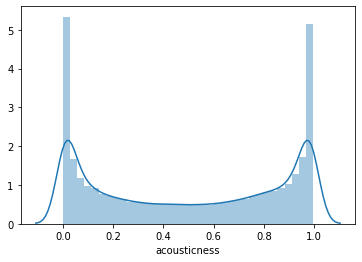

In [107]:
display(sns.distplot(features['acousticness']))

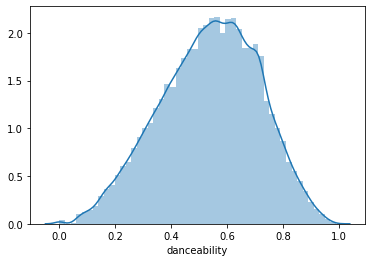

In [108]:
display(sns.distplot(features['danceability']))

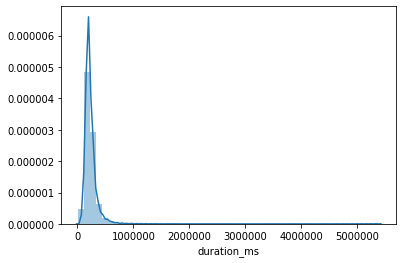

In [109]:
display(sns.distplot(features['duration_ms']))

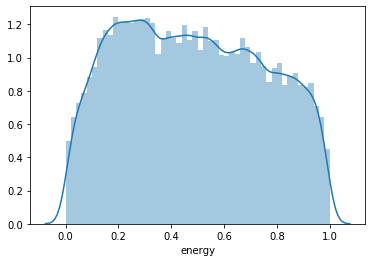

In [110]:
display(sns.distplot(features['energy']))

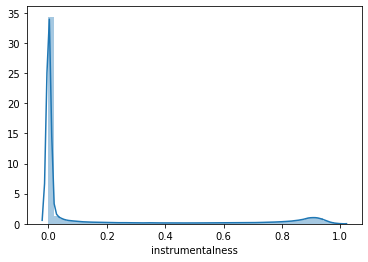

In [112]:
display(sns.distplot(features['instrumentalness']))

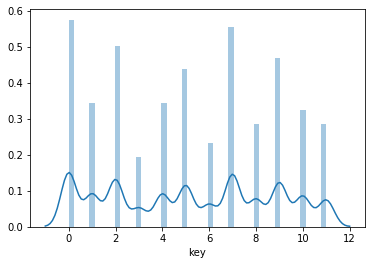

In [113]:
display(sns.distplot(features['key']))

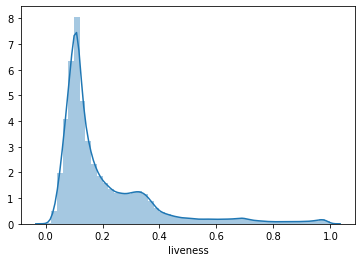

In [114]:
display(sns.distplot(features['liveness']))

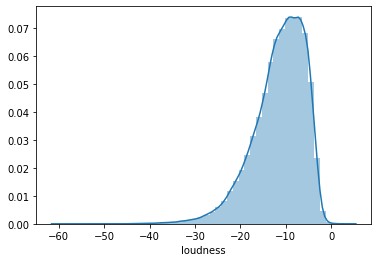

In [115]:
display(sns.distplot(features['loudness']))

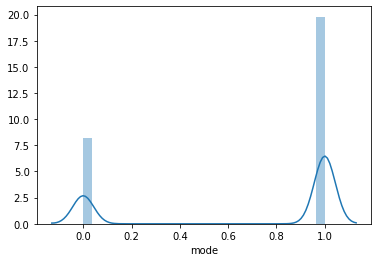

In [116]:
display(sns.distplot(features['mode']))

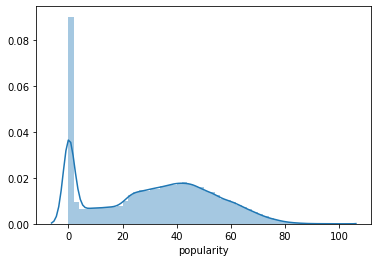

In [117]:
display(sns.distplot(features['popularity']))

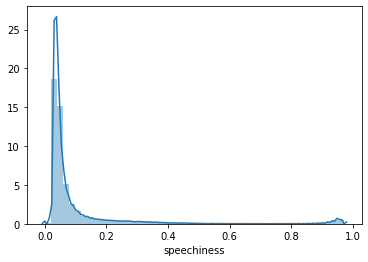

In [118]:
display(sns.distplot(features['speechiness']))

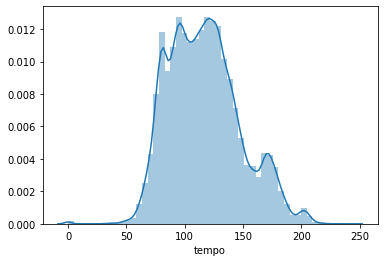

In [119]:
display(sns.distplot(features['tempo']))

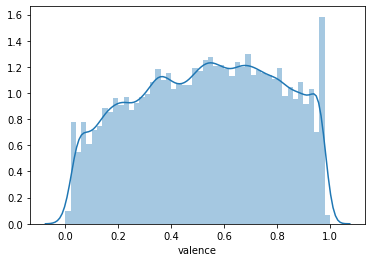

In [120]:
display(sns.distplot(features['valence']))

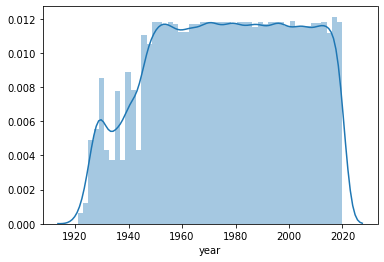

In [121]:
display(sns.distplot(features['year']))

## Checking the heatmap from transformed data

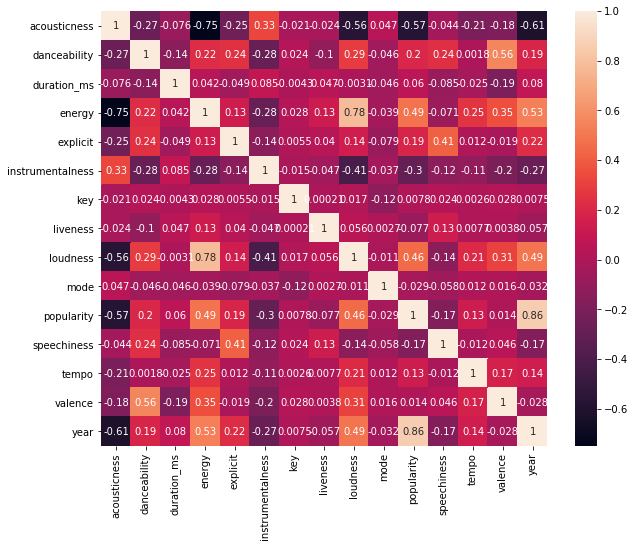

In [85]:
corr_matrix=features.corr(method='pearson')
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

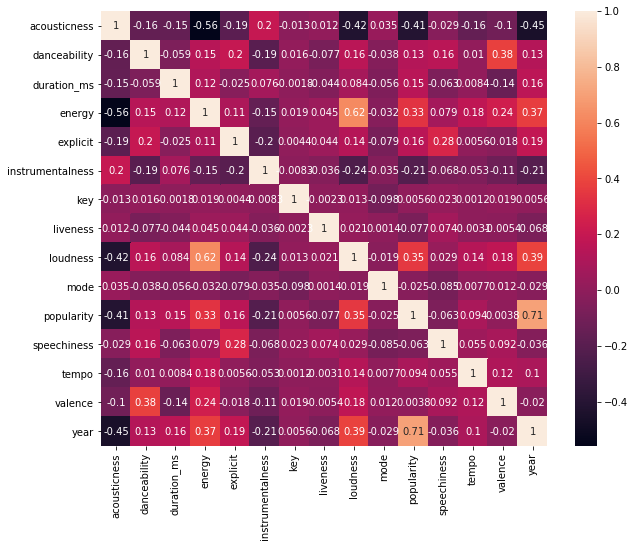

In [87]:
corr_matrix=features.corr(method='kendall')
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

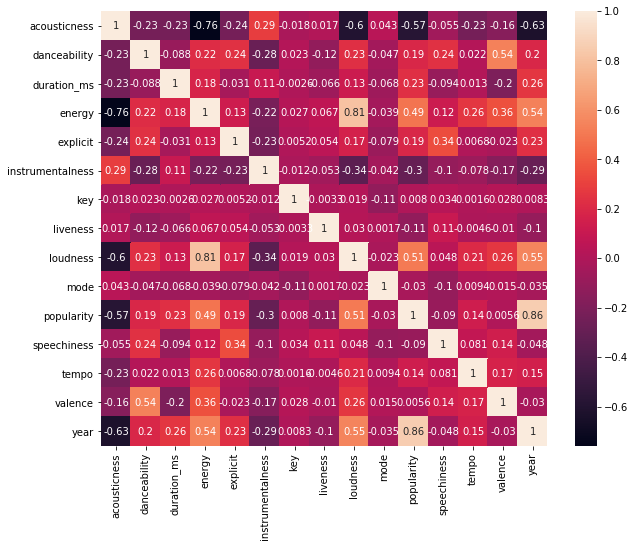

In [88]:
corr_matrix=features.corr(method='spearman')
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

#### Year vs Popularity

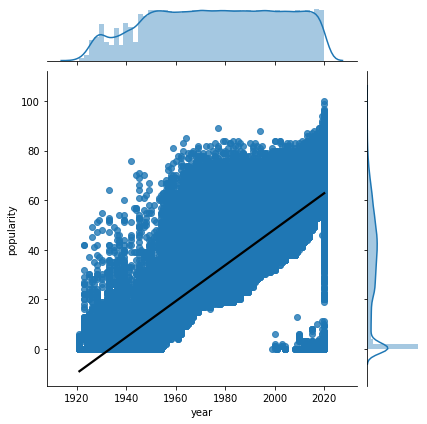

In [89]:
sns.jointplot(x="year", y="popularity", data=features, kind='reg',joint_kws={'line_kws':{'color':'black'}})

#### Energy vs Loudness

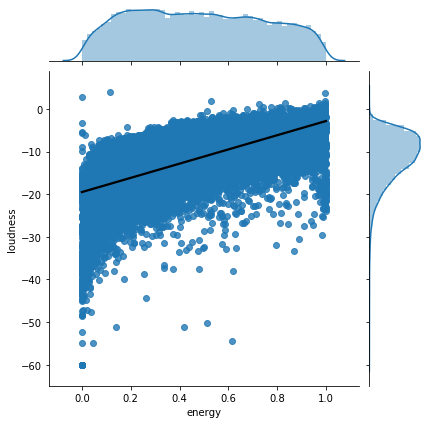

In [90]:
sns.jointplot(x="energy", y="loudness", data=features, kind='reg',joint_kws={'line_kws':{'color':'black'}})

#### Energy vs Acousticness

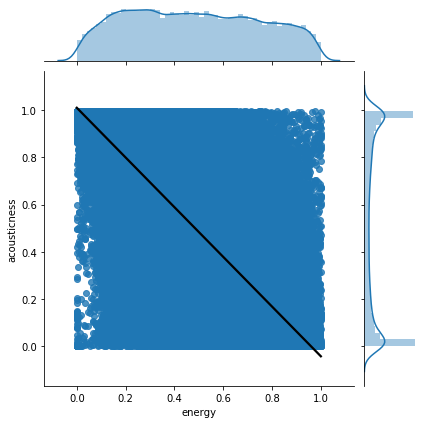

In [93]:
sns.jointplot(x="energy", y="acousticness", data=features, kind='reg',joint_kws={'line_kws':{'color':'black'}})

### Using VIF to check  multicollinearity

In [94]:
def get_vif(exogs, data):
    # initialize dictionaries
    vif_dict, tolerance_dict = {}, {}

    # create formula for each exogenous variable
    for exog in exogs:
        not_exog = [i for i in exogs if i != exog]
        formula = f"{exog} ~ {' + '.join(not_exog)}"

        # extract r-squared from the fit
        r_squared = smf.ols(formula, data=data).fit().rsquared

        # calculate VIF
        vif = 1/(1 - r_squared)
        vif_dict[exog] = vif

        # calculate tolerance
        tolerance = 1 - r_squared
        tolerance_dict[exog] = tolerance

    # return VIF DataFrame
    df_vif = pd.DataFrame({'VIF': vif_dict, 'Tolerance': tolerance_dict})

    return df_vif

In [97]:
get_vif(features,features)

,VIF,Tolerance
acousticness,3.061026,0.326688
danceability,1.969144,0.507835
duration_ms,1.077016,0.928491
energy,4.955799,0.201784
explicit,1.407580,0.710439
instrumentalness,1.373085,0.728287
key,1.015506,0.984731
liveness,1.101005,0.908261
loudness,3.203007,0.312207
mode,1.031373,0.969581


#### We can see that there is some multicollinearity among the features, but acceptable since VIF < 10 and Tolerance > 0.2. 
#### This way we'll proceed with the scaling and clustering.

## Scaling features

In [98]:
X.describe()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
count,170667.000000,170667.000000,1.706670e+05,170667.000000,170667.000000,170667.000000,170667.000000,170667.000000,170667.000000,170667.000000,170667.000000,170667.000000,170667.000000,170667.000000,170667.000000
mean,0.502085,0.537409,2.309437e+05,0.482409,0.084621,0.166996,5.199828,0.205835,-11.467503,0.706891,31.434648,0.098396,116.862457,0.528587,1976.790780
std,0.376035,0.176140,1.261145e+05,0.267645,0.278318,0.313465,3.515130,0.174800,5.697973,0.455189,21.828358,0.162737,30.707935,0.263168,25.919735
min,0.000000,0.000000,5.108000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1921.000000
25%,0.102000,0.415000,1.698270e+05,0.255000,0.000000,0.000000,2.000000,0.098800,-14.614500,0.000000,11.000000,0.034900,93.422000,0.317000,1956.000000
50%,0.516000,0.548000,2.074530e+05,0.471000,0.000000,0.000216,5.000000,0.136000,-10.579000,1.000000,33.000000,0.045000,114.730000,0.540000,1977.000000
75%,0.893000,0.668000,2.624000e+05,0.703000,0.000000,0.102000,8.000000,0.261000,-7.183000,1.000000,48.000000,0.075600,135.537500,0.747000,1999.000000
max,0.996000,0.988000,5.403500e+06,1.000000,1.000000,1.000000,11.000000,1.000000,3.855000,1.000000,100.000000,0.970000,243.507000,1.000000,2020.000000


In [99]:
X_prep = StandardScaler().fit_transform(X)

Now, all features will have the same weight.

In [100]:
pd.DataFrame(X_prep, columns=X.columns).head()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
0,1.276254,-1.467074,4.763330,-1.014065,-0.304045,2.268212,1.365579,2.626816,-1.514314,0.643929,-1.256839,-0.379733,-1.169358,-1.782848,-2.15245
1,0.611421,1.598683,-0.399723,-0.528346,-0.304045,-0.532743,0.512123,-0.262214,-0.170850,0.643929,-1.211027,1.945495,-1.821243,1.650709,-2.15245
2,1.220408,-1.188885,2.133926,-1.182199,-0.304045,2.379868,-0.625819,-0.599744,-0.593633,0.643929,-1.211027,-0.396324,-0.212436,-1.858846,-2.15245
3,1.236364,-1.489783,-0.166069,-0.647908,-0.304045,-0.532654,-0.056848,1.002094,0.377592,0.643929,-1.302651,-0.387106,-0.545576,-1.381583,-2.15245
4,1.209771,-0.677926,-0.509465,-1.081319,-0.304045,-0.532737,-0.625819,0.132525,0.240701,0.643929,-1.348463,-0.371130,-0.494905,-1.047194,-2.15245


## Clustering the songs with K-Means

In [101]:
kmeans = KMeans(n_clusters=8, random_state=1234)
kmeans.fit(X_prep)

KMeans(random_state=1234)

Now we have our "model", let's get the clusters and how many observations has each cluster.



In [102]:
clusters = kmeans.predict(X_prep)
pd.Series(clusters).value_counts().sort_index()

0    18384
1    27971
2     8784
3    49147
4    26966
5    11796
6     5098
7    22521
dtype: int64

Now let's see to which group was assigned every song.

In [103]:
X_df = pd.DataFrame(X)
X_df["cluster"] = clusters
X_df.head()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year,cluster
0,0.982,0.279,831667,0.211,0,0.878000,10,0.665,-20.096,1,4,0.0366,80.954,0.0594,1921,0
1,0.732,0.819,180533,0.341,0,0.000000,7,0.160,-12.441,1,5,0.4150,60.936,0.9630,1921,1
2,0.961,0.328,500062,0.166,0,0.913000,3,0.101,-14.850,1,5,0.0339,110.339,0.0394,1921,0
3,0.967,0.275,210000,0.309,0,0.000028,5,0.381,-9.316,1,3,0.0354,100.109,0.1650,1921,4
4,0.957,0.418,166693,0.193,0,0.000002,3,0.229,-10.096,1,2,0.0380,101.665,0.2530,1921,4


## Choosing K

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

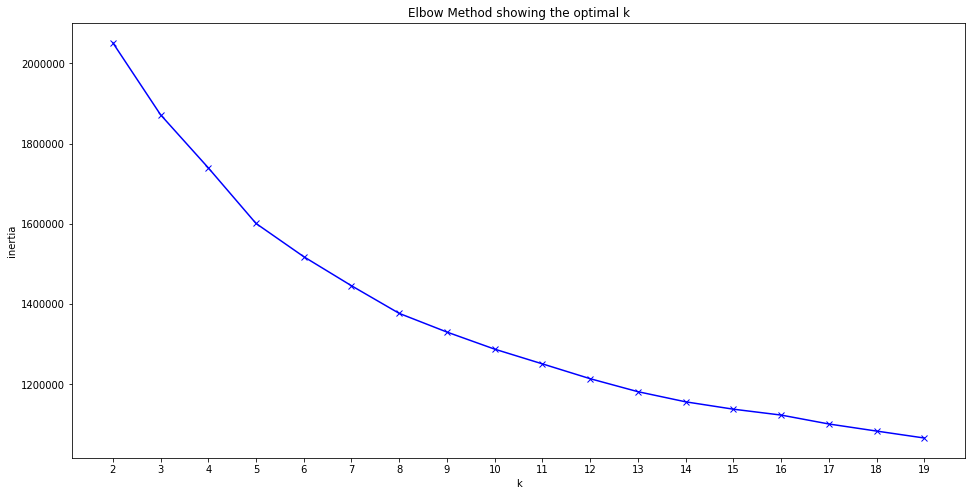

In [104]:
K = range(2, 20)
inertia = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X_prep)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

## Silhouette Score (Impossible to calculate)

In [ ]:
#K = range(5, 6)
#silhouette = []

#for k in K:
#    kmeans = KMeans(n_clusters=k,
#                    random_state=1234)
#    kmeans.fit(X_prep)
#    silhouette.append(silhouette_score(X_prep, kmeans.predict(X_prep)))


#plt.figure(figsize=(16,8))
#plt.plot(K, silhouette, 'bx-')
#plt.xlabel('k')
#plt.ylabel('silhouette score')
#plt.xticks(np.arange(min(K), max(K)+1, 1.0))
#plt.title('Elbow Method showing the optimal k')

### Saving the file to perform some analysis with Tableau

In [122]:
X_df.to_csv('Files\gnod_results.csv')

# Tableau Visualizations

![title](Files/Dashboard_1.png)

# Final Proposition

### Function Check Song (Availability + HOT + Details)

In [140]:
def check_hot_ad(string, db):
    df1 = db.where((db['name'].str.casefold() == string.lower())).dropna(thresh=2)

    if string.lower() in list(db['name'].str.casefold()):
            print('This song is Hot and it is available!')
            print()
            print((df1))
    else:
            print("Sorry, we've checked", len(db),"songs but we're not able to find what you're looking for :(")

In [242]:
X_df

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year,cluster
0,0.98200,0.279,831667,0.211,0,0.878000,10,0.6650,-20.096,1,4,0.0366,80.954,0.0594,1921,0
1,0.73200,0.819,180533,0.341,0,0.000000,7,0.1600,-12.441,1,5,0.4150,60.936,0.9630,1921,1
2,0.96100,0.328,500062,0.166,0,0.913000,3,0.1010,-14.850,1,5,0.0339,110.339,0.0394,1921,0
3,0.96700,0.275,210000,0.309,0,0.000028,5,0.3810,-9.316,1,3,0.0354,100.109,0.1650,1921,4
4,0.95700,0.418,166693,0.193,0,0.000002,3,0.2290,-10.096,1,2,0.0380,101.665,0.2530,1921,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170662,0.43100,0.625,210123,0.775,0,0.000052,0,0.1200,-5.199,1,57,0.0248,101.961,0.5880,2020,3
170663,0.00336,0.650,194621,0.613,1,0.000000,9,0.2670,-6.130,0,55,0.1280,149.972,0.0804,2020,5
170664,0.04860,0.478,155668,0.873,0,0.000000,4,0.3740,-3.637,1,61,0.1220,104.365,0.7390,2020,3
170665,0.02390,0.849,122587,0.536,1,0.000000,1,0.1260,-7.307,1,83,0.3490,141.964,0.3080,2020,5


In [219]:
X_df2 = pd.concat([X_df, data_full['name']], axis=1 )
X_df3 = pd.concat([X_df2, data_full['artists']], axis=1 )
X_df4 = pd.concat([X_df3, data_full['release_date']], axis=1 )
X_df5 = pd.concat([X_df4, data_full['id']], axis=1 )

In [220]:
X_df5

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year,cluster,name,artists,release_date,id
0,0.98200,0.279,831667,0.211,0,0.878000,10,0.6650,-20.096,1,4,0.0366,80.954,0.0594,1921,0,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...","['Sergei Rachmaninoff', 'James Levine', 'Berli...",1921,4BJqT0PrAfrxzMOxytFOIz
1,0.73200,0.819,180533,0.341,0,0.000000,7,0.1600,-12.441,1,5,0.4150,60.936,0.9630,1921,1,Clancy Lowered the Boom,['Dennis Day'],1921,7xPhfUan2yNtyFG0cUWkt8
2,0.96100,0.328,500062,0.166,0,0.913000,3,0.1010,-14.850,1,5,0.0339,110.339,0.0394,1921,0,Gati Bali,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,1921,1o6I8BglA6ylDMrIELygv1
3,0.96700,0.275,210000,0.309,0,0.000028,5,0.3810,-9.316,1,3,0.0354,100.109,0.1650,1921,4,Danny Boy,['Frank Parker'],1921,3ftBPsC5vPBKxYSee08FDH
4,0.95700,0.418,166693,0.193,0,0.000002,3,0.2290,-10.096,1,2,0.0380,101.665,0.2530,1921,4,When Irish Eyes Are Smiling,['Phil Regan'],1921,4d6HGyGT8e121BsdKmw9v6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170662,0.43100,0.625,210123,0.775,0,0.000052,0,0.1200,-5.199,1,57,0.0248,101.961,0.5880,2020,3,7 Summers,[Morgan Wallen],2020-08-14 00:00:00,0Z0kNthq0sS4lvGz9SSlBF
170663,0.00336,0.650,194621,0.613,1,0.000000,9,0.2670,-6.130,0,55,0.1280,149.972,0.0804,2020,5,Legends Never Die,[Juice WRLD],2020-07-10 00:00:00,6o3QUC5oAE4g6WxRIFcZtb
170664,0.04860,0.478,155668,0.873,0,0.000000,4,0.3740,-3.637,1,61,0.1220,104.365,0.7390,2020,3,hole in the bottle,[Kelsea Ballerini],2020-02-28 00:00:00,2EzFVkHWMMWmdwW08AlCK8
170665,0.02390,0.849,122587,0.536,1,0.000000,1,0.1260,-7.307,1,83,0.3490,141.964,0.3080,2020,5,BLAME IT ON BABY (DELUXE),[DaBaby],2020-08-04 00:00:00,4Z5FyQlevoHoa5FsIVKZju


In [222]:
data_full_c1, data_full_c2 = [x for _, x in X_df5.groupby(X_df5['cluster'] == 0)]

In [225]:
data_full_c1, data_full_c3 = [x for _, x in X_df5.groupby(X_df5['cluster'] == 1)]

In [227]:
data_full_c1, data_full_c4 = [x for _, x in X_df5.groupby(X_df5['cluster'] == 2)]

In [228]:
data_full_c1, data_full_c5 = [x for _, x in X_df5.groupby(X_df5['cluster'] == 3)]

In [229]:
data_full_c1, data_full_c6 = [x for _, x in X_df5.groupby(X_df5['cluster'] == 4)]

In [230]:
data_full_c1, data_full_c7 = [x for _, x in X_df5.groupby(X_df5['cluster'] == 5)]

In [231]:
data_full_c1, data_full_c8 = [x for _, x in X_df5.groupby(X_df5['cluster'] == 6)]

In [232]:
data_full_c1, data_full_c9 = [x for _, x in X_df5.groupby(X_df5['cluster'] == 7)]

In [238]:
len(data_full_c2 + data_full_c3 + data_full_c4 + data_full_c5 + data_full_c6 + data_full_c7 + data_full_c8 + data_full_c9)

170667

### Creating a function to get the suggestions from the clusters

In [258]:
def suggestions(string, db=hot_100_full, data=data_full):
    df1 = db.where((db['name'].str.casefold() == string.lower())).dropna(thresh=2)
    df2 = data.where((data_full_c2['name'].str.casefold() == string.lower())).dropna(thresh=2)
    df3 = data.where((data_full_c3['name'].str.casefold() == string.lower())).dropna(thresh=2)
    df4 = data.where((data_full_c4['name'].str.casefold() == string.lower())).dropna(thresh=2)
    df5 = data.where((data_full_c5['name'].str.casefold() == string.lower())).dropna(thresh=2)
    df6 = data.where((data_full_c6['name'].str.casefold() == string.lower())).dropna(thresh=2)
    df7 = data.where((data_full_c7['name'].str.casefold() == string.lower())).dropna(thresh=2)
    df8 = data.where((data_full_c8['name'].str.casefold() == string.lower())).dropna(thresh=2)
    df9 = data.where((data_full_c9['name'].str.casefold() == string.lower())).dropna(thresh=2)
    
    
    if string.lower() in list(db['name'].str.casefold()):
            print('This song is Hot and it is available!')
            print()
            display(df1)
            print()
            suggestion_df1 = hot_100_full['name'].sample(n=5, random_state=1234)
            print("You may like this similar songs:", display(suggestion_df1[:]))
    elif string.lower() in list(data_full_c2['name'].str.casefold()):
            print('This song is Cool and it is available')
            print()
            display(df2)
            print()
            suggestion_df2 = data_full_c2['name'].sample(n=5, random_state=1234)
            print("You may like this similar songs:", display(suggestion_df2[:]))
    elif string.lower() in list(data_full_c3['name'].str.casefold()):
            print('This song is Amazing and it is available')
            print()
            display(df3)
            print()
            suggestion_df3 = data_full_c3['name'].sample(n=5, random_state=1234)
            print("You may like this similar songs:", display(suggestion_df3[:]))
    elif string.lower() in list(data_full_c4['name'].str.casefold()):
            print('This song is Awesome and it is available')
            print()
            display(df4)
            print()
            suggestion_df4 = data_full_c4['name'].sample(n=5, random_state=1234)
            print("You may like this similar songs:", display(suggestion_df4[:]))
    elif string.lower() in list(data_full_c5['name'].str.casefold()):
            print('This song is Beaultiful and it is available')
            print()
            display(df5)
            print()
            suggestion_df5 = data_full_c5['name'].sample(n=5, random_state=1234)
            print("You may like this similar songs:", display(suggestion_df5[:]))
    elif string.lower() in list(data_full_c6['name'].str.casefold()):
            print('This song is Nice and it is available')
            print()
            display(df6)
            print()
            suggestion_df6 = data_full_c6['name'].sample(n=5, random_state=1234)
            print("You may like this similar songs:", display(suggestion_df6[:]))
    elif string.lower() in list(data_full_c7['name'].str.casefold()):
            print('This song is Great and it is available')
            print()
            display(df7)
            print()
            suggestion_df7 = data_full_c7['name'].sample(n=5, random_state=1234)
            print("You may like this similar songs:", display(suggestion_df7[:]))
    elif string.lower() in list(data_full_c8['name'].str.casefold()):
            print('This song is Terrific and it is available')
            print()
            display(df8)
            print()
            suggestion_df8 = data_full_c8['name'].sample(n=5, random_state=1234)
            print("You may like this similar songs:", display(suggestion_df8[:]))
    elif string.lower() in list(data_full_c9['name'].str.casefold()):
            print('This song is Very Good and it is available')
            print()
            display(df9)
            print()
            suggestion_df9 = data_full_c9['name'].sample(n=5, random_state=1234)
            print("You may like this similar songs:", display(suggestion_df9[:]))
    else:
            print('No song this time! Sorry :(')

In [261]:
a = input()

Blinding Lights


In [262]:
suggestions(a, hot_100_full)

This song is Hot and it is available!



,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
21,0.00146,['The Weeknd'],0.514,200040.0,0.73,0.0,0VjIjW4GlUZAMYd2vXMi3b,0.000095,1.0,0.0897,-5.934,1.0,Blinding Lights,96.0,2020-03-20,0.0598,171.005,0.334,2020.0


40          Levitating (feat. DaBaby)
35                             Wonder
81    Champagne Night - From Songland
61            Love You Like I Used To
98          BLAME IT ON BABY (DELUXE)
Name: name, dtype: object

You may like this similar songs: None
